# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Logistic Regression (IRLS)</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Fisher Scoring</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = 'is_bad'

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Fisher Scoring</span>

A custom implementation of Fisher scoring for Logistic Regression (MLE).

In [2]:
import numpy as np
from scipy.special import xlogy

class FisherScoringLogisticRegression:
    def __init__(self, epsilon=1e-3, max_iter=1000):
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.beta = None
        self.loss_history = []
        self.beta_history = []

    @staticmethod
    def logistic_function(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def compute_loss(y, p):
        return -np.mean(xlogy(y, p) + xlogy(1 - y, 1 - p))

    def fit(self, X, y):
        self.beta = np.zeros((X.shape[1], 1))
        y = y.reshape(-1, 1)

        for iteration in range(self.max_iter):
            p = self.logistic_function(X @ self.beta)
            W = np.diag((p * (1 - p)).ravel())
            I = X.T @ W @ X
            U = X.T @ (y - p)
            
            current_loss = self.compute_loss(y, p)
            self.loss_history.append(current_loss)
            
            beta_new = self.beta + np.linalg.inv(I) @ U
            if np.linalg.norm(beta_new - self.beta) < self.epsilon:
                print(f"Convergence reached after {iteration + 1} iterations.")
                self.beta = beta_new
                break
            
            self.beta = beta_new
            self.beta_history.append(self.beta.flatten())
            if iteration == self.max_iter - 1:
                print("Maximum iterations reached without convergence.")

    def predict_proba(self, X):
        return self.logistic_function(X @ self.beta).flatten()

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) > threshold).astype(int)

Convergence reached after 8 iterations.


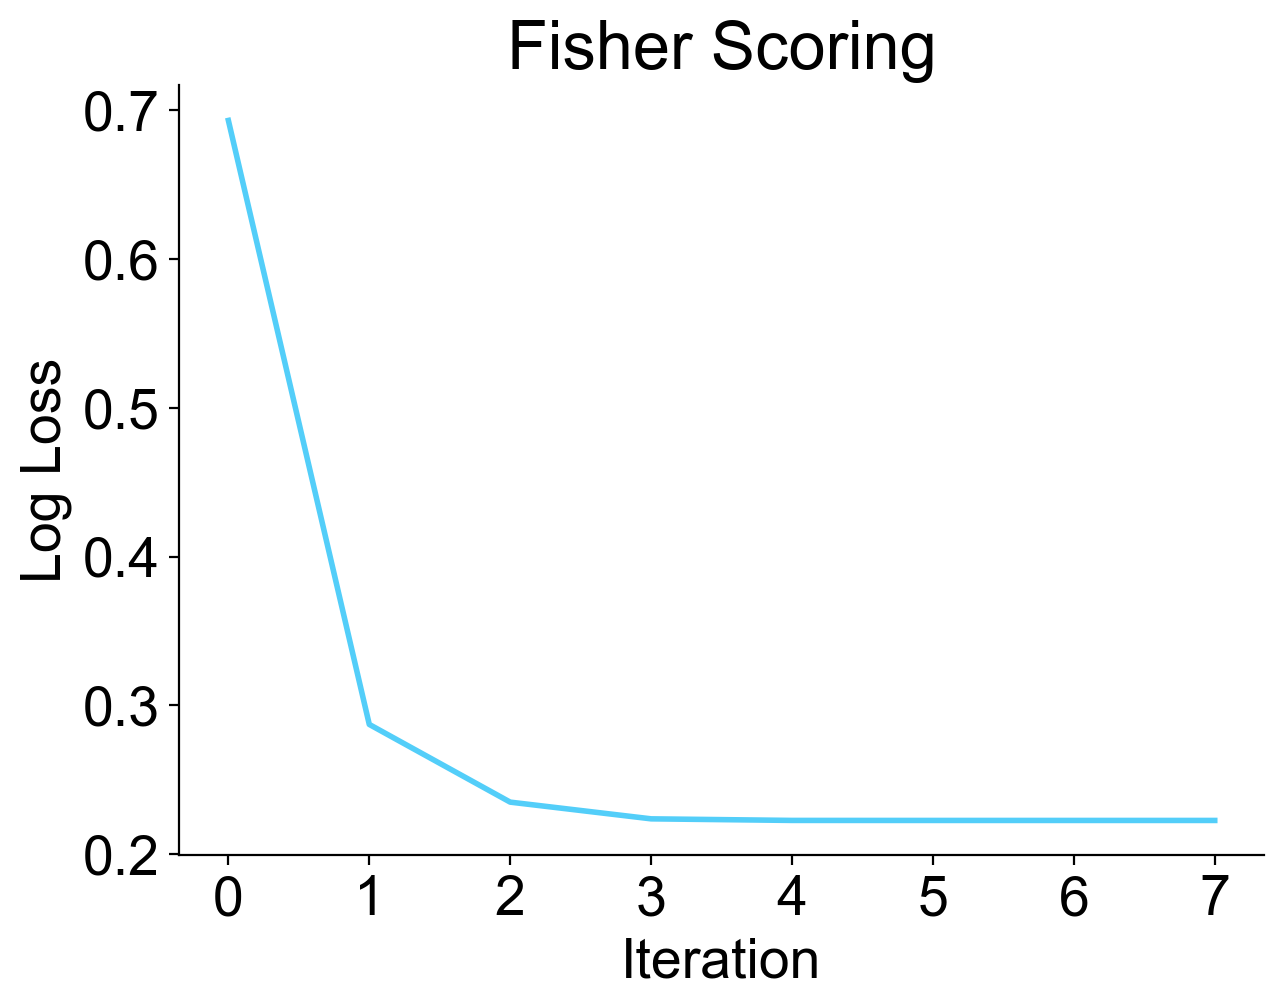

In [3]:
# Assume X and y are your design matrix and response vector respectively
model = FisherScoringLogisticRegression(epsilon=1e-10, max_iter=100)
model.fit(X.loc[ix_train].values, y[ix_train].values)

# After fitting, you can access the model's parameters, predictions, and loss history
beta = model.beta
predictions = model.predict(X.loc[ix_test].values)
loss_history = model.loss_history

# Optionally, visualize the loss history
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(7, 5), dpi=100)
# set font size to larger size
plt.rcParams.update({'font.size': 20})
# set font to Arial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.plot(loss_history, color='#53cef9', linewidth=2)
# set blackground to black
plt.xticks(range(len(loss_history)))
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Fisher Scoring')
# Disable upper and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

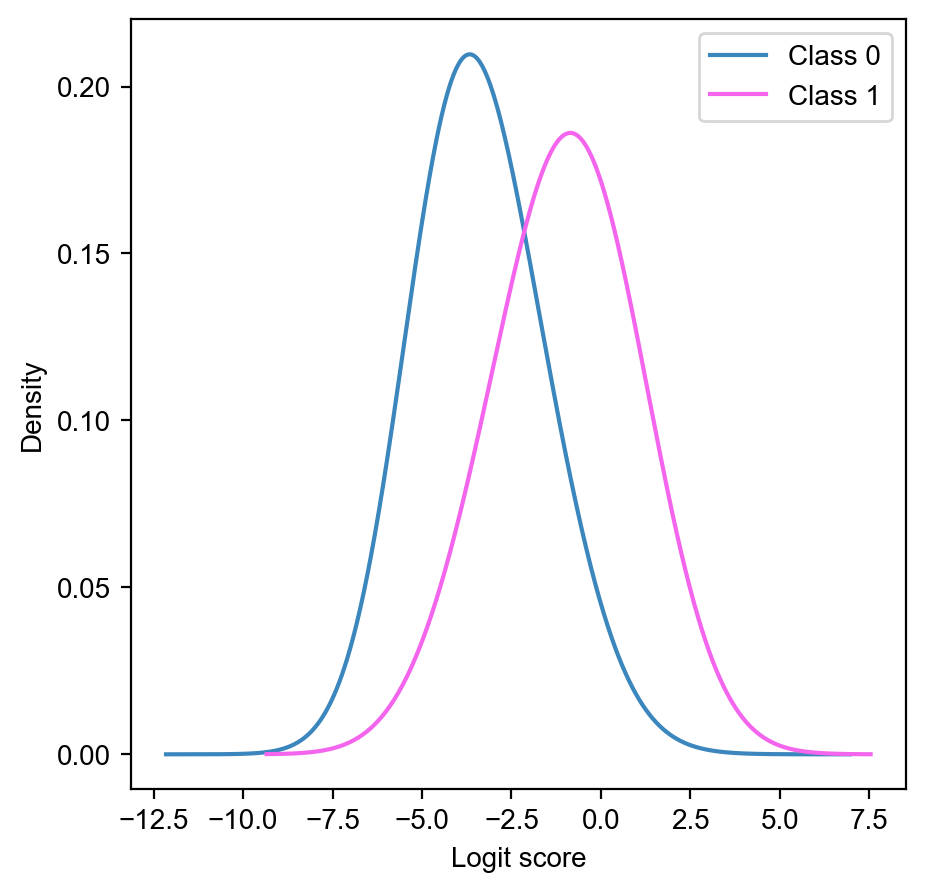

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit

# Assuming 'summary' and 'y' are defined as per your context
proba_class_1 = model.predict_proba(X.loc[ix_train].values).flatten()
# Ensure probabilities are within (0, 1) for logit
proba_class_1_clipped = np.clip(proba_class_1, 1e-6, 1-1e-6)
logit_class_1 = logit(proba_class_1_clipped)

# Directly create DataFrame without extra flattening
probs_and_labels = pd.DataFrame({
    'prob_is_bad': proba_class_1_clipped,
    'logit_is_bad': logit_class_1,
    'is_bad': y.loc[ix_train].values.flatten()  # Ensure this aligns correctly
})

plt.rcParams.update({'font.size': 10})

# Plot KDEs for both classes in one figure for better comparison
plt.figure(figsize=(5, 5))
for is_bad, group_data in probs_and_labels.groupby('is_bad'):
    group_data['logit_is_bad'].plot.kde(
        bw_method=1.0,
        label=f'Class {is_bad}',
        color="#f465ed" if is_bad else "#3b86bc"
    )
plt.xlabel('Logit score')
plt.legend()
plt.show()

Optimal cutoff based on Youden's J statistic: -2.0827465875708264


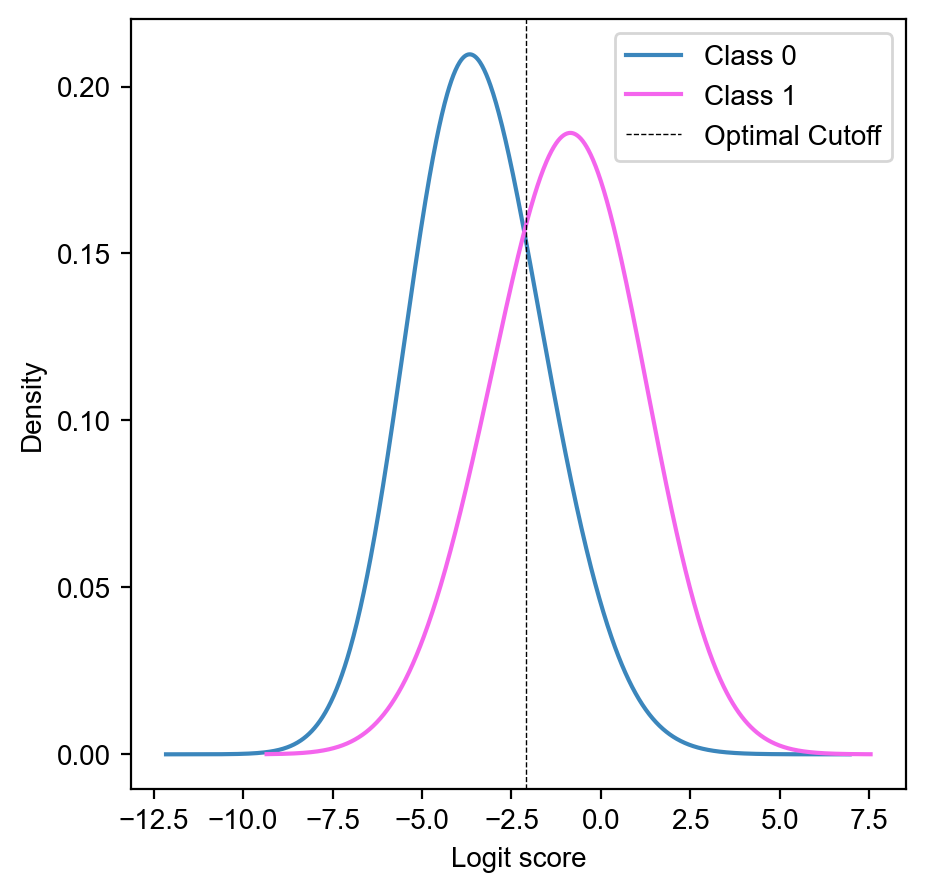

In [5]:
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(probs_and_labels['is_bad'], probs_and_labels['logit_is_bad'])

# Calculate Youden's J statistic
j_scores = tpr - fpr
j_ordered = sorted(zip(j_scores, thresholds))
optimal_threshold = j_ordered[-1][1]  # Threshold with the highest J score

print(f"Optimal cutoff based on Youden's J statistic: {optimal_threshold}")

# Plotting with the optimal cutoff highlighted
plt.figure(figsize=(5, 5))
for is_bad, group_data in probs_and_labels.groupby('is_bad'):
    group_data['logit_is_bad'].plot.kde(
        bw_method=1.0,
        label=f'Class {is_bad}',
        color="#f465ed" if is_bad else "#3b86bc"
    )
plt.axvline(x=optimal_threshold, color='k', linestyle='--', linewidth=0.5, label='Optimal Cutoff')
plt.xlabel('Logit score')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import log_loss, roc_auc_score
print("Coefficients:")
print(np.array(model.beta.T).T)

log_loss_score = log_loss(y.loc[ix_train], model.predict_proba(X.loc[ix_train].values))

predictions = model.predict_proba(X.loc[ix_train].values)

gini = 2 * roc_auc_score(y.loc[ix_train], predictions) - 1
print(f"Gini train: {gini:.2%}")

predictions = model.predict_proba(X.loc[ix_test].values)

gini = 2 * roc_auc_score(y.loc[ix_test], predictions) - 1
print(f"Gini test: {gini:.2%}")

Coefficients:
[[ 3.06773531e+00]
 [-4.74814166e-02]
 [ 2.56886084e-02]
 [ 3.85109857e-02]
 [-1.10214349e-02]
 [ 6.85653496e-06]]
Gini train: 75.05%
Gini test: 74.10%


### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">scikit-learn Logistic Regression</span>

Here we compare results with scikit-learn's Logistic Regression.

In [7]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(
    solver='newton-cg',
    penalty=None,
    fit_intercept=False,
    max_iter=1000
)
model_lr.fit(X.loc[ix_train], y.loc[ix_train])

print("Coefficients:")
print(model_lr.coef_.T)

predictions = model_lr.predict_proba(X.loc[ix_train])[:,1]

gini = 2 * roc_auc_score(y.loc[ix_train], predictions) - 1
print(f"Gini train: {gini:.2%}")

predictions = model_lr.predict_proba(X.loc[ix_test])[:,1]

gini = 2 * roc_auc_score(y.loc[ix_test], predictions) - 1
print(f"Gini test: {gini:.2%}")

Coefficients:
[[ 3.06773531e+00]
 [-4.74814166e-02]
 [ 2.56886084e-02]
 [ 3.85109857e-02]
 [-1.10214349e-02]
 [ 6.85653496e-06]]
Gini train: 75.05%
Gini test: 74.10%


In [8]:
# Fit log loss landscape for 2 features

features_to_fit = ['revolving_utilization_of_unsecured_lines', 'account_never_delinq_percent']
X_train = X.loc[ix_train][features_to_fit].values
X_test = X.loc[ix_test][features_to_fit].values

model = FisherScoringLogisticRegression(epsilon=1e-10, max_iter=100)

model.fit(X_train, y.loc[ix_train].values)

Convergence reached after 8 iterations.


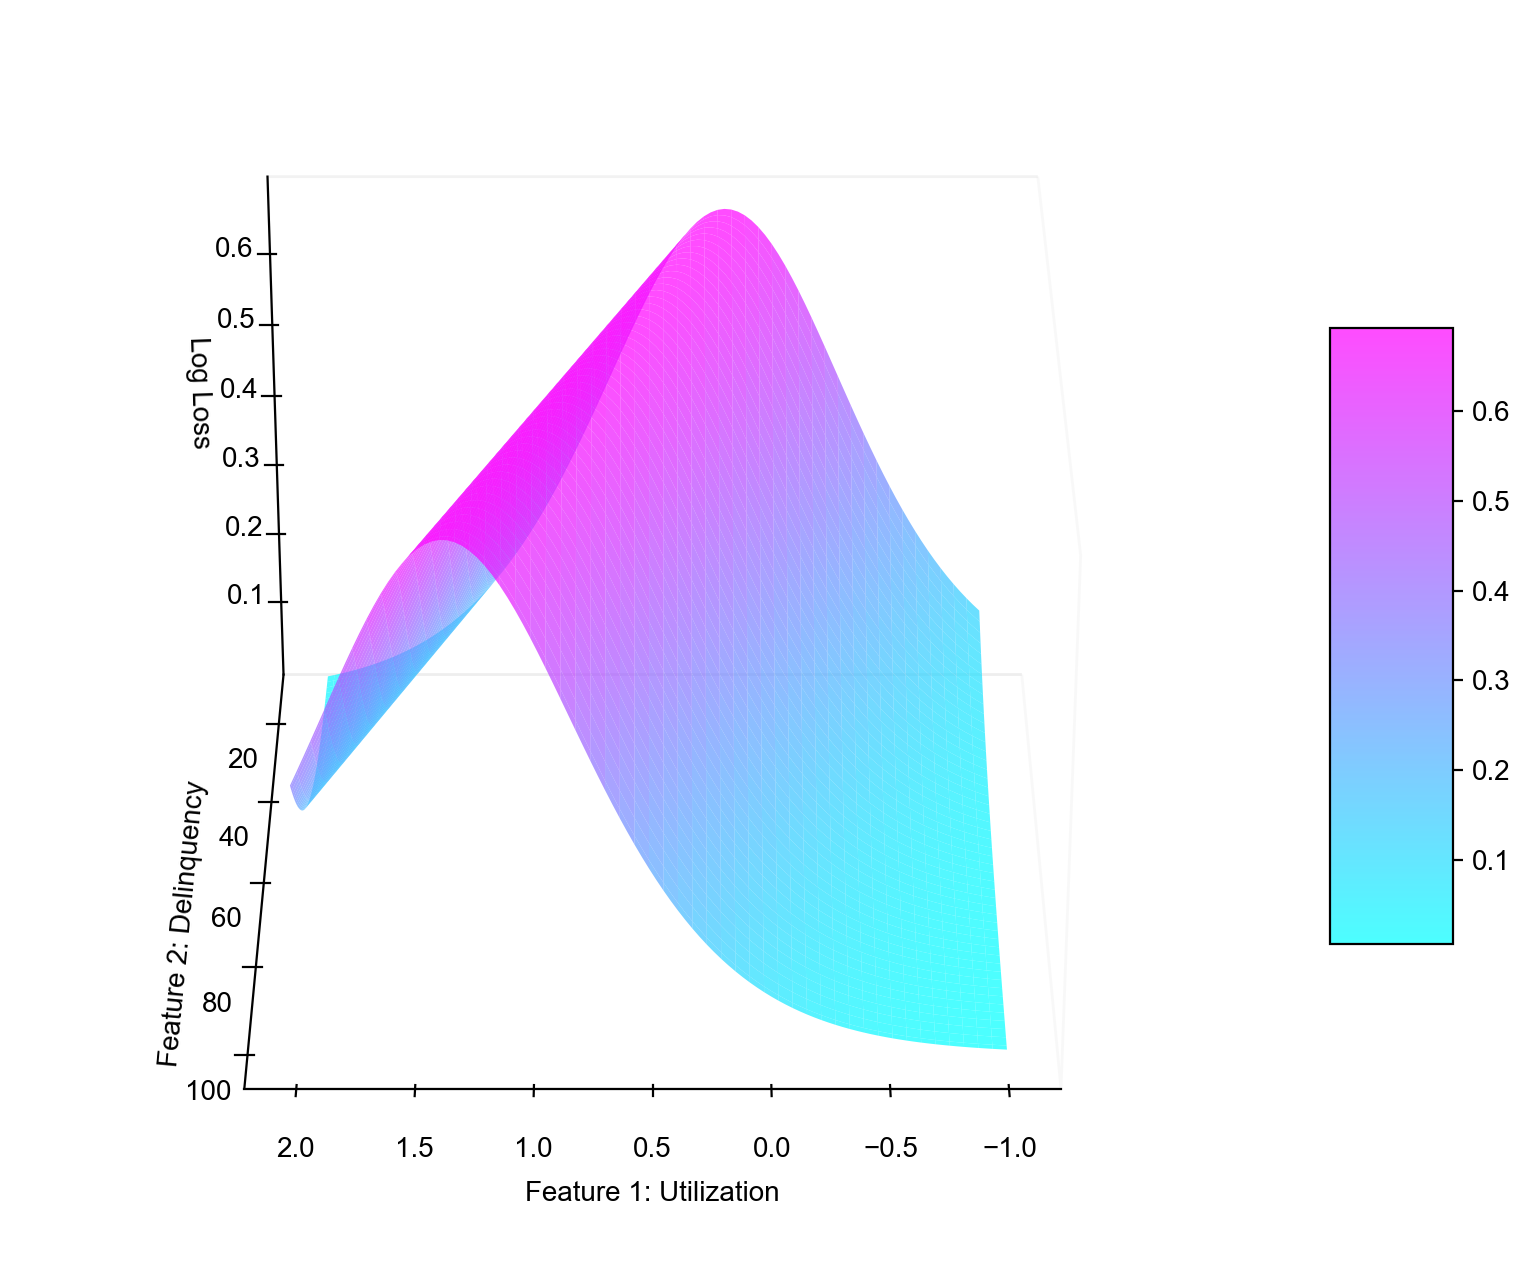

In [9]:
# Assuming 'model' is a trained instance of LogisticRegression and 'X_train' is your training set

# Create a mesh grid for the feature space
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict class probabilities on the grid
grid_predictions = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])

# A synthetic label (confidence) for visualization purposes
synthetic_labels = grid_predictions.copy() # (grid_predictions > 0.5).astype(int)

# Compute log loss for each point on the grid
losses = -synthetic_labels * np.log(grid_predictions) - (1 - synthetic_labels) * np.log(1 - grid_predictions)
losses = losses.reshape(xx.shape)

# Create the 3D plot for the loss landscape
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xx, yy, losses, cmap='cool', alpha=0.7)

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
# Add labels and title
ax.set_xlabel('Feature 1: Utilization')
ax.set_ylabel('Feature 2: Delinquency')
ax.view_init(elev=30, azim=90)  # Elevate and rotate
ax.set_zlabel('Log Loss')

ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)
ax.tick_params(axis='z', which='both', length=0)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# # Now we also make the gridlines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# Hide the spines (borders)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()